Assignment 3: 

Name: Pratik Acharya

UID: 117513615

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Pratik Acharya

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [2]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 88.9MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [3]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [4]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    # plt.figure(figsize=scale* plt.figaspect(1))
    plt.figure()
    plt.imshow(img)
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code (15 pt)

In [5]:
def ransacF(x1, y1, x2, y2, itr = 1000):
    # Find normalization matrix
    # Transform point set 1 and 2
    # RANSAC based 8-point algorithm
    # YOUR CODE HERE:

    x1Norm, y1Norm, T1Norm = normalize(x1, y1)
    x2Norm, y2Norm, T2Norm = normalize(x2, y2)

    pts1 = np.array([x1, y1])
    pts2 = np.array([x2, y2])

    pts1Norm = np.array([x1Norm, y1Norm])
    pts2Norm = np.array([x2Norm, y2Norm])

    # RANSAC
    maxInliers = 0
    bestF = None
    bestInliers = None

    for i in tqdm(range(0, itr)):
        # Randomly select 8 points
        randomIndex = random.sample(range(0, len(x1)), 8)

        x1Random = pts1Norm[0, randomIndex]
        y1Random = pts1Norm[1, randomIndex]

        x2Random = pts2Norm[0, randomIndex]
        y2Random = pts2Norm[1, randomIndex]

        # Compute fundamental matrix
        F = computeF(x1Random, y1Random,
                     x2Random, y2Random)

        # Count inliers
        inliers = getInliers(pts1Norm, pts2Norm, F, 0.01)

        if len(inliers) > maxInliers:
            maxInliers = len(inliers)
            bestF = F
            bestInliers = inliers

    print("Max Inliers:", maxInliers)

    F = T2Norm.T @ bestF @ T1Norm
    return F


def getInliers(pt1, pt2, F, thresh):
    # Function: implement the criteria checking inliers.
    # YOUR CODE HERE:

    inliers = []

    for i in range(0, pt1.shape[1]):
        x1 = pt1[0, i]
        y1 = pt1[1, i]

        x2 = pt2[0, i]
        y2 = pt2[1, i]

        x1 = np.array([x1, y1, 1])
        x2 = np.array([x2, y2, 1])

        x2tFx1 = x1.T @ F @ x2
        x2tFx1 = np.abs(x2tFx1)
        if x2tFx1 < thresh:
            inliers.append(i)

    return inliers


def normalize(x, y):
    # Function: find the transformation to make it zero mean and the variance as sqrt(2)
    # YOUR CODE HERE:

    centroidX = np.mean(x)
    centroidY = np.mean(y)

    recenteredX = x - centroidX
    recenteredY = y - centroidY

    scale = np.sqrt(
        2) / np.sqrt(np.mean(np.add(recenteredX ** 2, recenteredY ** 2)))

    LMat = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
    TMat = np.array([[1, 0, -centroidX], [0, 1, -centroidY], [0, 0, 1]])

    T = LMat @ TMat

    # Check if the transformation is correct
    normalized = T @ np.hstack((x, y, np.ones(x.shape))).T

    return normalized[0], normalized[1], T


def computeF(x1, y1, x2, y2):
    #  Function: compute fundamental matrix from corresponding points
    # YOUR CODE HERE:

    A = np.zeros((x1.shape[0], 9))

    for i in range(0, len(x1)):
        A[i] = np.array([[x1[i] * x2[i], x1[i] * y2[i], x1[i], y1[i]
                          * x2[i], y1[i] * y2[i], y1[i], x2[i], y2[i], 1]])

    U, S, V = np.linalg.svd(A, full_matrices=True)
    F = V[-1].reshape(3, 3)

    U, S, V = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0
    S = np.diag(S)
    F = U @ S @ V

    return F

# Used from StackOverflow
def draw_epipolar_lines(img1, img2, pts1, pts2, F):
    # find epipolar lines
    l1 = np.dot(F, pts1.T)
    l2 = np.dot(F.T, pts2.T)

    # draw epipolar lines
    for i in range(pts1.shape[0]):
        # draw epipolar lines on image 1
        cv2.line(img1, (0, int(-l1[2, i]/l1[1, i])), (img1.shape[1], int(
            (-l1[2, i] - l1[0, i]*img1.shape[1])/l1[1, i])), (0, 255, 0), 1)

        # draw epipolar lines on image 2
        cv2.line(img2, (0, int(-l2[2, i]/l2[1, i])), (img2.shape[1], int(
            (-l2[2, i] - l2[0, i]*img2.shape[1])/l2[1, i])), (0, 255, 0), 1)

    return img1, img2

100%|██████████| 2000/2000 [00:09<00:00, 206.34it/s]


Max Inliers: 145
[[-3.99922109e-08 -7.36008106e-06  1.25661371e-03]
 [ 6.67004124e-06 -2.82586592e-07  5.24030414e-03]
 [-1.17721918e-03 -5.04571230e-03 -3.33439468e-02]]


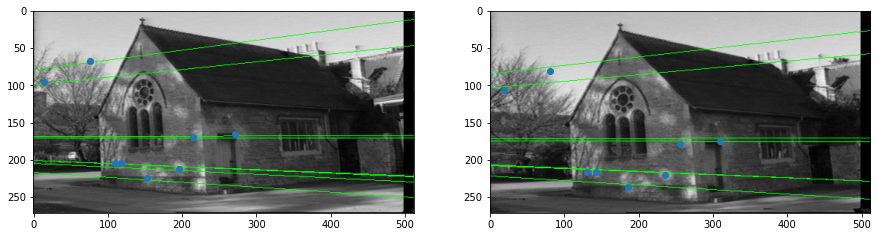

In [6]:
F = ransacF(x1, y1, x2, y2, 2000)

print(F)

im1 = cv2.imread('/content/Part1_data/chapel00.png')
im2 = cv2.imread('/content/Part1_data/chapel01.png')
selected_idx = np.random.randint(0, x1.shape[0], 8)
sel_x1, sel_y1, sel_x2, sel_y2 = x1[selected_idx], y1[selected_idx], x2[selected_idx], y2[selected_idx]
plt.figure(figsize=(15, 15))
draw_epipolar_lines(im1, im2, np.vstack((sel_x1.T, sel_y1.T, np.ones(
    sel_x1.shape).T)).T, np.vstack((sel_x2.T, sel_y2.T, np.ones(sel_x2.shape).T)).T, F)
plt.subplot(1, 2, 1), plt.imshow(im1), plt.scatter(sel_x1, sel_y1)
plt.subplot(1, 2, 2), plt.imshow(im2), plt.scatter(sel_x2, sel_y2),
plt.show()


### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.


> For the inliers vs outliers test, the epipolar constraint of x2' * F * x1 was used to make sure each matching pair was within a tolerance of a threshold value (i.e. 0.01), and the F with the maximum nuber of inliers was chosen.




*   Display the estimated fundamental matrix F after normalizing to unit length


> Displayed in the code result


*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [7]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 71.5MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 77.5MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [8]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code (15 pt)

In [9]:
# YOUR CODE HERE: 

def get_orb_features(img):
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def stitch_images(im1, im2, im3):
    images = [im1, im2, im3]

    # ORB
    feature_coord = []
    feature_desc = []

    for img in images:
        kp, des = get_orb_features(img)
        feature_coord.append(np.array([kp[i].pt for i in range(len(kp))]))
        feature_desc.append(des)

    def get_matches(desc1, desc2):
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(desc1, desc2)
        matches = sorted(matches, key=lambda x: x.distance)
        return matches

    matches1 = get_matches(feature_desc[0], feature_desc[1])
    matches2 = get_matches(feature_desc[1], feature_desc[2])

    goodMatches1 = matches1[:int(len(matches1) * 0.2)]
    goodMatches2 = matches2[:int(len(matches2) * 0.2)]


    # get the coordinates of the matched features
    src1 = np.array([feature_coord[0][matches1[i].queryIdx]
                    for i in range(len(goodMatches1))])
    dest1 = np.array([feature_coord[1][matches1[i].trainIdx]
                      for i in range(len(goodMatches1))])

    src2 = np.array([feature_coord[1][matches2[i].queryIdx]
                    for i in range(len(goodMatches2))])
    dest2 = np.array([feature_coord[2][matches2[i].trainIdx]
                      for i in range(len(goodMatches2))])

    def Ransac(src, dest, n_iter, threshold):
        maxInliers = 0
        bestH = None
        for i in tqdm(range(n_iter)):
            idx = np.random.randint(0, src.shape[0], 8)
            src_sample = src[idx]
            dest_sample = dest[idx]
            H = est_homography(src_sample, dest_sample)
            dest_est = apply_homography(H, src)
            dist = np.linalg.norm(dest_est - dest, axis=1)
            inliers = np.where(dist < threshold)[0].shape[0]
            if inliers > maxInliers:
                maxInliers = inliers
                bestH = H
        return bestH

    H1 = Ransac(src1, dest1, 2000, 0.2)
    H2 = Ransac(dest2, src2, 2000, 0.2)

    print("H1 : ")
    print(H1)
    print("H2 : ")
    print(H2)
    

    # apply homography
    warped1 = cv2.warpPerspective(im1, H1, (im1.shape[1], im1.shape[0]))
    warped2 = cv2.warpPerspective(im3, H2, (im3.shape[1], im3.shape[0]))

    # find corners of the image
    corners = np.array([[0, 0], [0, im1.shape[0]], [
        im1.shape[1], im1.shape[0]], [im1.shape[1], 0]])
    warped_corners1 = apply_homography(H1, corners)
    warped_corners2 = apply_homography(H2, corners)

    # find max min of the corners
    min_x = min(warped_corners1[:, 0].min(), warped_corners2[:, 0].min(), 0)
    max_x = max(warped_corners1[:, 0].max(),
                warped_corners2[:, 0].max(), im1.shape[1])
    min_y = min(warped_corners1[:, 1].min(), warped_corners2[:, 1].min(), 0)
    max_y = max(warped_corners1[:, 1].max(),
                warped_corners2[:, 1].max(), im1.shape[0])

    # find the translation matrix
    T = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

    # apply translation
    warped1 = cv2.warpPerspective(
        im1, T @ H1, (int(max_x - min_x), int(max_y - min_y)))
    warped2 = cv2.warpPerspective(
        im3, T @ H2, (int(max_x - min_x), int(max_y - min_y)))

    # translate im2
    im2 = cv2.warpPerspective(im2, T, (int(max_x - min_x), int(max_y - min_y)))

    warped_corners_mid = apply_homography(T, corners)
    min_x = min(warped_corners_mid[:, 0])
    max_x = max(warped_corners_mid[:, 0])
    min_y = min(warped_corners_mid[:, 1])
    max_y = max(warped_corners_mid[:, 1])

    warped1 = warped1[:, :int(min_x)]
    warped2 = warped2[:, int(max_x):]
    im2 = im2[:, int(min_x):int(max_x)]

    # concatenate the images
    result = np.concatenate((warped1, im2, warped2), axis=1)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result

100%|██████████| 2000/2000 [00:01<00:00, 1509.76it/s]


H1 : 
[[-6.70679298e-03  7.73449780e-05  9.99200428e-01]
 [-5.97213860e-04 -6.69491834e-03  3.83891792e-02]
 [-1.59851318e-06 -1.60470199e-06 -5.88303509e-03]]
H2 : 
[[ 6.42569456e-03  3.02851663e-04  9.94318391e-01]
 [-4.85857988e-04  7.25038492e-03 -1.05748225e-01]
 [-2.80667479e-06  9.69741639e-07  7.35290340e-03]]


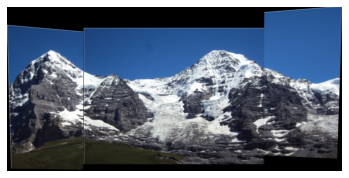

100%|██████████| 2000/2000 [00:01<00:00, 1552.75it/s]


H1 : 
[[ 3.73371276e-03  2.24572932e-05 -9.91507865e-01]
 [ 4.48602566e-04  3.30172461e-03 -1.29916791e-01]
 [ 1.63960015e-06 -3.71581058e-07  2.95594929e-03]]
H2 : 
[[ 3.64515132e-03  7.31097984e-05  9.97747145e-01]
 [-9.40171742e-04  4.76944609e-03  6.66318307e-02]
 [-2.89489495e-06  2.71120670e-07  4.88986257e-03]]


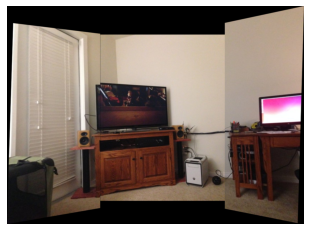

In [16]:
im1 = cv2.imread('/content/hill/1.JPG')
im2 = cv2.imread('/content/hill/2.JPG')
im3 = cv2.imread('/content/hill/3.JPG')
stitchedImage = stitch_images(im1, im2, im3)

show_image(stitchedImage)

im1 = cv2.imread('/content/tv/1.jpg')
im2 = cv2.imread('/content/tv/2.jpg')
im3 = cv2.imread('/content/tv/3.jpg')
stitchedImage = stitch_images(im1, im2, im3)

show_image(stitchedImage)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
  


> The incorrect matches can be checked by warping all the matched points from the src image using the homography matrix and then using a threshold to remove the incorrect matches.


*  Display the best homography H after RANSAC 


> Displayed in the code result 


*  Display the blended images


> Displayed in the code result 



### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [11]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 115MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

### Code (20 pt)

In [19]:
# Remove the nan value
# YOUR CODE HERE

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE

  track_x = x - np.nanmean(x, axis=0)
  track_y = y - np.nanmean(y, axis=0)

  # Constructing matrix D
  D = np.hstack((track_x, track_y)).T

  # Check number of nan values in each column
  nan_count = np.count_nonzero(np.isnan(D), axis=0)
  nan_count = np.where(nan_count > 0)[0]

  # Remove columns with nan values
  D = np.delete(D, nan_count, axis=1)

  # SVD
  U, W, V = np.linalg.svd(D)

  U3 = U[:, :3]
  W3 = W[:3]
  V3 = V[:3, :]

  # Constructing matrix A
  A = U3 @ np.diag(np.sqrt(W3))
  S = np.diag(np.sqrt(W3)) @ V3

  # ATilde = A[:6, :]

  AMatrix = np.zeros((int(A.shape[0]*3/2), 9))

  for i in range(0, int(A.shape[0]/2)):
      temp = A[2*i, :].reshape(3, 1) * A[2*i, :]
      AMatrix[3*i, :] = temp.reshape(1, 9)
      temp = A[2*i, :].reshape(3, 1) * A[2*i, :]
      AMatrix[(3*i)+1, :] = temp.reshape(1, 9)
      temp = A[(2*i), :].reshape(3, 1) * A[(2*i)+1, :]
      AMatrix[(3*i)+2, :] = temp.reshape(1, 9)

  K = np.asarray([1, 1, 0]*int(A.shape[0]/2))

  # solve Ax=K
  L = np.linalg.lstsq(AMatrix, K, rcond=None)[0].reshape(3, 3)

  U, S_, V = np.linalg.svd(L, full_matrices=True)

  # # QR deconposition
  Q, R = np.linalg.qr(U @ np.diag(np.sqrt(S_)))
  AT = A @ R
  ST = R.T @ S

  # Only odd rows
  Ai = AT[0::2, :]

  # Only even rows
  Aj = AT[1::2, :]

  # Cross product Ai x Aj
  Ak = np.cross(Ai, Aj)
  Ak = Ak / np.linalg.norm(Ak, axis=1).reshape(Ak.shape[0], 1)

  # plot 3d points S

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.scatter(Ak[:, 0], Ak[:, 1], c='r', marker='o')
  plt.title("Camera Positons X-Y Plane")
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.scatter(Ak[:, 1], Ak[:, 2], c='b', marker='o')
  plt.title("Camera Positons Y-Z Plane")
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.scatter(Ak[:, 0], Ak[:, 2], c='g', marker='o')
  plt.title("Camera Positons X-Z Plane")
  plt.show()

    
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(72, 180)
  plt.title("3D Point Cloud View 1")
  ax.scatter(ST[0, :], ST[1, :], ST[2, :])

  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(45, -123)
  plt.title("3D Point Cloud View 2")
  ax.scatter(ST[0, :], ST[1, :], ST[2, :])
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(85, 155)
  plt.title("3D Point Cloud View 3")
  ax.scatter(ST[0, :], ST[1, :], ST[2, :])
  plt.show()


  return ST

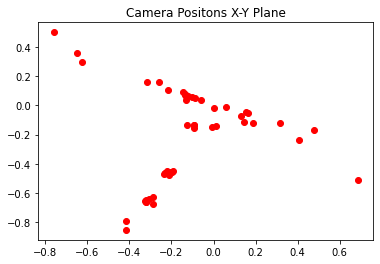

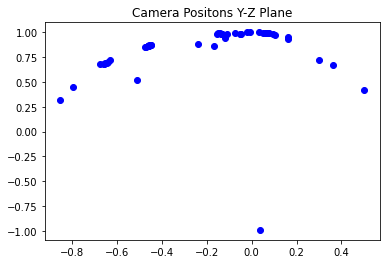

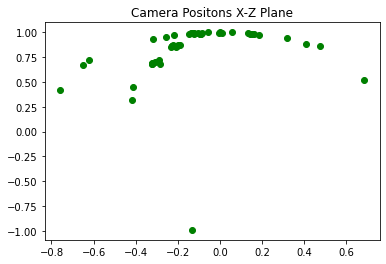

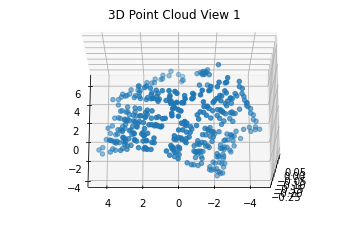

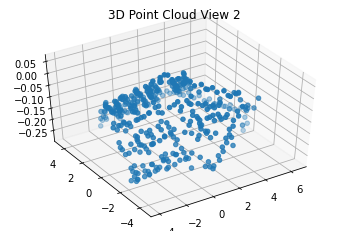

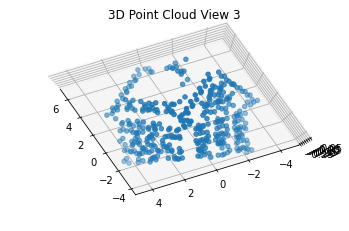

In [20]:
track_x = data['track_x']
track_y = data['track_y']
Points3D = affineSFM(track_x, track_y)

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992